In [1]:
%matplotlib inline
import os
import numpy as np
import pickle
import matplotlib as mpl

import readdy_learn.analyze.analyze as ana
import readdy_learn.analyze.basis as basis

import pynumtools.kmc as kmc

#mpl.rcParams['figure.figsize'] = (13, 13)
import matplotlib.pyplot as plt
import scipy.signal as ss

/srv/public/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_overview(plot_functions, n_rows=2, n_cols=2, size_factor=1.):
    plt.figure(1, figsize=(5*n_cols*size_factor,3.5*n_rows*size_factor))
    n_plots = n_rows * n_cols
    idx = 1
    for pf in plot_functions:
        if idx > n_plots:
            break
        plt.subplot(n_rows, n_cols, idx)
        #plt.xscale("log")
        pf()
        plt.legend(loc="best")
        idx += 1

    #plt.subplots_adjust(top=0.88, bottom=0.08, left=0.10, right=0.95, hspace=0.4, wspace=0.35)
    plt.tight_layout(pad=0.6, w_pad=2.0, h_pad=2.0)

In [3]:
desired_rates = np.array([
    1.8, # DA -> DA + MA, transcription A
    2.1, # MA -> MA + A, translation A
    1.3, # MA -> 0, decay
    1.5, # A -> 0, decay
    2.2, # DB -> DB + MB, transcription B
    2.0, # MB -> MB + B, translation B
    2.0, # MB -> 0, decay
    2.5, # B -> 0, decay
    3.2, # DC -> DC + MC, transcription C
    3.0, # MC -> MC + C, translation C
    2.3, # MC -> 0, decay
    2.5, # C -> 0, decay
    # self regulation
    0., # MA + A -> A, A regulates A
    0., # MB + B -> B, B regulates B
    0., # MC + C -> C, C regulates C
    # cyclic forward
    0., # MB + A -> A, A regulates B
    0., # MC + B -> B, B regulates C
    0., # MA + C -> C, C regulates A
    # cyclic backward
    6., # MC + A -> A, A regulates C
    4., # MB + C -> C, C regulates B
    3., # MA + B -> B, B regulates A
    # nonsense reactions, mRNA eats protein self
    0.,0.,0.,
    # nonsense reactions, mRNA eats protein cyclic forward
    0.,0.,0.,
    # nonsense reactions, mRNA eats protein  cyclic backward
    0.,0.,0.,
    # nonsense reactions, protein eats protein self
    0.,0.,0.,
    # nonsense reactions, protein eats protein cyclic forward
    0.,0.,0.,
    # nonsense reactions, protein eats protein cyclic backward
    0.,0.,0.,
    # nonsense reactions, protein becomes protein cyclic forward
    0.,0.,0.,
    # nonsense reactions, protein becomes protein cyclic backward
    0.,0.,0.,
])

In [4]:
data_dir = "./simple_gradient/"

In [21]:
rates_files =  {
    2000: "est_rates_for_2000.npy",
    1000: "est_rates_for_1000.npy",
    500: "est_rates_for_500.npy",
    200: "est_rates_for_200.npy",
    100: "est_rates_for_100.npy",
    60: "est_rates_for_60.npy",
    50: "est_rates_for_50.npy",
    40: "est_rates_for_40.npy",
    30: "est_rates_for_30.npy",
    25: "est_rates_for_25.npy",
    20: "est_rates_for_20.npy",
    10: "est_rates_for_10.npy",
    5: "est_rates_for_5.npy",
    2: "est_rates_for_2.npy",
    1: "est_rates_for_1.npy",
}

In [22]:
cv_results_files = {
    2000: "cv_results_for_2000.pickle",
    1000: "cv_results_for_1000.pickle",
    500: "cv_results_for_500.pickle",
    200: "cv_results_for_200.pickle",
    100: "cv_results_for_100.pickle",
    60: "cv_results_for_60.pickle",
    50: "cv_results_for_50.pickle",
    40: "cv_results_for_40.pickle",
    30: "cv_results_for_30.pickle",
    25: "cv_results_for_25.pickle",
    20: "cv_results_for_20.pickle",
    10: "cv_results_for_10.pickle",
    5: "cv_results_for_5.pickle",
    2: "cv_results_for_2.pickle",
    1: "cv_results_for_1.pickle",
}
cv_result_nonoise = "cv_results_for_infty.pickle"

## Badness as function n_realisations

In [23]:
rates_nonoise = np.load(os.path.join(data_dir,"est_rates_for_infty.npy"))
est_rates = dict()
for n, filename in rates_files.items():
    path = os.path.join(data_dir, filename)
    est_rates[n] = np.load(path)

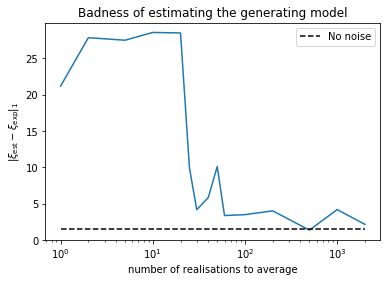

In [24]:
n_realisations = []
badness = []
for n, rates in est_rates.items():
    n_realisations.append(n)
    norm = np.sum(np.absolute(rates - desired_rates))
    badness.append(norm)

n_realisations = np.array(n_realisations)
badness = np.array(badness)
plt.plot(n_realisations, badness, )

nonoise_badness = np.sum(np.absolute(rates_nonoise - desired_rates))
plt.plot([1.,2000], [nonoise_badness, nonoise_badness], "k--", label="No noise")

plt.legend(loc="best")
plt.xlabel("number of realisations to average")
plt.title("Badness of estimating the generating model")
plt.ylabel(r"$\|\xi_\mathrm{est} - \xi_\mathrm{exp}\|_1$")
plt.xscale("log")
plt.show()

## Look at models in transition regime

Text(0.5,1,'n_realisations = 20')

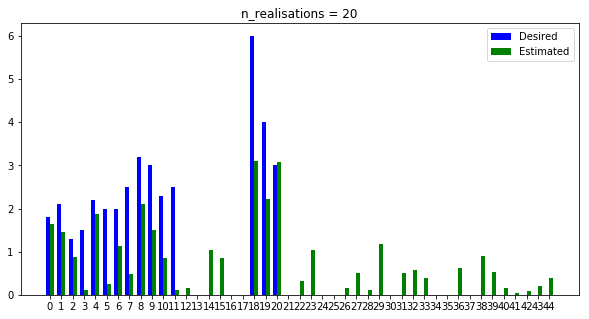

In [33]:
ana.plot_rates_bar(desired_rates, est_rates[20])
plt.title("n_realisations = "+str(20))

Text(0.5,1,'n_realisations = 30')

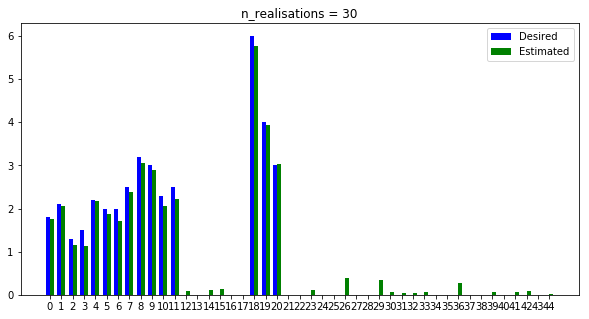

In [32]:
ana.plot_rates_bar(desired_rates, est_rates[30])
plt.title("n_realisations = "+str(30))

## Cross validation results

In [25]:
cv_results = dict()
for n, filename in cv_results_files.items():
    path = os.path.join(data_dir, filename)
    with open(path, "rb") as file:
        cv_results[n] = pickle.load(file)

In [26]:
cv_results

{1: <readdy_learn.analyze.estimator.CV at 0x7fbd146955c0>,
 2: <readdy_learn.analyze.estimator.CV at 0x7fbd17bb77b8>,
 5: <readdy_learn.analyze.estimator.CV at 0x7fbd14e96978>,
 10: <readdy_learn.analyze.estimator.CV at 0x7fbd13dfbd68>,
 20: <readdy_learn.analyze.estimator.CV at 0x7fbd17bb7dd8>,
 25: <readdy_learn.analyze.estimator.CV at 0x7fbd1245ac18>,
 30: <readdy_learn.analyze.estimator.CV at 0x7fbd124defd0>,
 40: <readdy_learn.analyze.estimator.CV at 0x7fbd13df6c18>,
 50: <readdy_learn.analyze.estimator.CV at 0x7fbd17bb7630>,
 60: <readdy_learn.analyze.estimator.CV at 0x7fbd15ae1470>,
 100: <readdy_learn.analyze.estimator.CV at 0x7fbd15ae1d68>,
 200: <readdy_learn.analyze.estimator.CV at 0x7fbd124a4278>,
 500: <readdy_learn.analyze.estimator.CV at 0x7fbd611d29e8>,
 1000: <readdy_learn.analyze.estimator.CV at 0x7fbd1253b518>,
 2000: <readdy_learn.analyze.estimator.CV at 0x7fbd17bb71d0>}

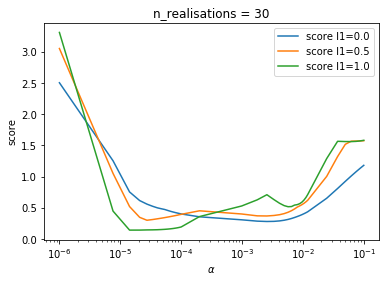

In [31]:
plot_cv(30)

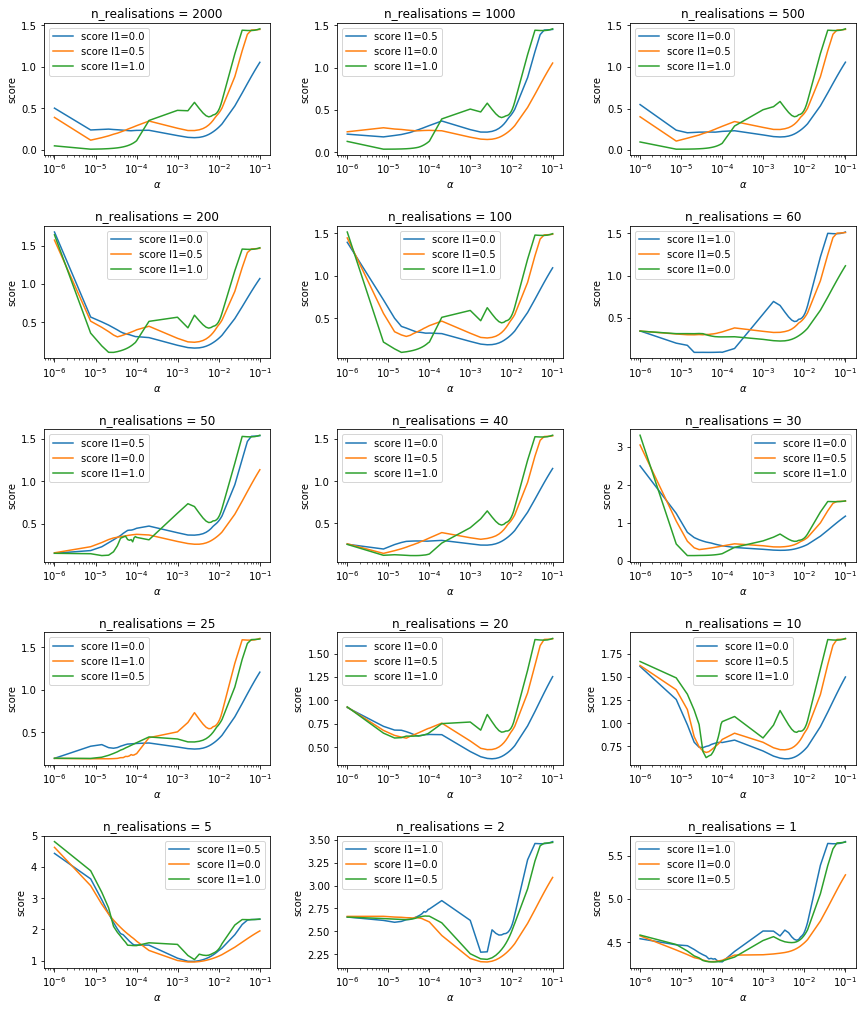

In [27]:
def plot_cv(n):
    ana.plot_cv_results(cv_results[n], mainscore=0, best_params_ix_l1=None)
    plt.title("n_realisations = "+str(n))
    plt.xscale("log")

pfs = []
for n in cv_results.keys():
    pfs.append(
        lambda _n=n: plot_cv(_n)
    )

plot_overview(pfs, n_cols=3, n_rows=5, size_factor=0.8)